In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

mohs_train = pd.read_csv("/kaggle/input/playground-series-s3e25/train.csv")
mohs_test = pd.read_csv("/kaggle/input/playground-series-s3e25/test.csv")

In [2]:
mohs_train.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [3]:
# Analyse the initial dataset
mohs_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


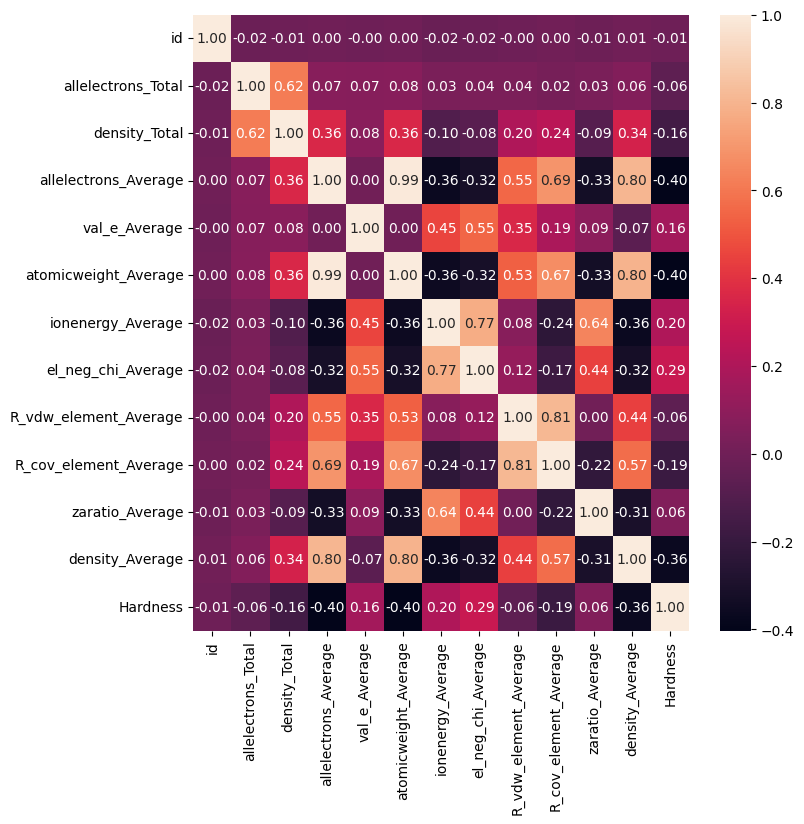

In [4]:
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(mohs_train.corr(), annot=True, fmt=".2f")
plt.plot();

In [5]:
mohs_y = mohs_y = mohs_train["Hardness"].to_numpy()
mohs_train = mohs_train.drop(columns="Hardness")

def preprocess(mohs):
    # drop unwanted features
    mohs_train = mohs.drop(columns=["id", "zaratio_Average", "R_vdw_element_Average", "allelectrons_Total"])

    print(mohs_train.info())

    s = StandardScaler()
    mohs_train = s.fit_transform(mohs_train)
    return mohs_train

mohs_train = preprocess(mohs_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   density_Total          10407 non-null  float64
 1   allelectrons_Average   10407 non-null  float64
 2   val_e_Average          10407 non-null  float64
 3   atomicweight_Average   10407 non-null  float64
 4   ionenergy_Average      10407 non-null  float64
 5   el_neg_chi_Average     10407 non-null  float64
 6   R_cov_element_Average  10407 non-null  float64
 7   density_Average        10407 non-null  float64
dtypes: float64(8)
memory usage: 650.6 KB
None


In [6]:
from xgboost import XGBRegressor as xgbr
from sklearn.model_selection import cross_val_score

xgb = xgbr(eta=0.03, n_estimators=300, booster="gbtree", max_depth=7)
models = [("xgb", xgb)]
model = xgb

for m, model in models:
    print(m)
    scores = cross_val_score(model, mohs_train, mohs_y, scoring="neg_mean_squared_error", cv=5)
    print(scores)
    print(scores.mean())
    print("-" * 20)

xgb
[-1.47762057 -1.47777866 -1.58464295 -1.49107425 -1.51546539]
-1.509316363427174
--------------------


In [7]:
# extract id
idd = mohs_test["id"]
mohs_test = preprocess(mohs_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6939 entries, 0 to 6938
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   density_Total          6939 non-null   float64
 1   allelectrons_Average   6939 non-null   float64
 2   val_e_Average          6939 non-null   float64
 3   atomicweight_Average   6939 non-null   float64
 4   ionenergy_Average      6939 non-null   float64
 5   el_neg_chi_Average     6939 non-null   float64
 6   R_cov_element_Average  6939 non-null   float64
 7   density_Average        6939 non-null   float64
dtypes: float64(8)
memory usage: 433.8 KB
None


In [8]:
model.fit(mohs_train, mohs_y)
res = model.predict(mohs_test)

final = pd.concat([idd, pd.Series(res)], axis=1)

In [9]:
final.index = final["id"]
final = final.drop(columns="id")
final = final.rename(columns={0: "Hardness"})
final.head()

,Hardness
id,
10407,2.624918
10408,3.201873
10409,5.588112
10410,4.121660
10411,5.641539


In [10]:
final.to_csv("final.csv")